In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Taken from ARK Fintech Innovation ETF.

In [2]:
start_date = '2023-01-01'
end_date = '2023-12-30'

# arkf innovation fund
# assets = ['COIN', 'SHOP', 'SQ', 'DKNG', 'PATH', 'ADYEN.AS', 'HOOD', 'GLBE', 'MELI', 'TWLO',
#         'TOST', 'INTU', 'ROKU', 'PINS', 'STNE', 'RBLX', 'SOFI', 'DSY.PA', 'PLTR', 'NU',
#         'TDOC', 'BILL', 'KSPI', '4689.T', 'AVDX', 'NVDA', 'META', 'CRWD', 'ICE', 'SPOT', 'Z']

# assets = ["AAPL",   # Apple Inc. (Technology)
#           "JPM",    # JPMorgan Chase & Co. (Finance)
#           "AMZN",   # Amazon.com Inc. (Retail)
#           "BA",     # The Boeing Company (Aerospace)
#           "NFLX",   # Netflix, Inc. (Entertainment)
#           "PG",     # Procter & Gamble Company (Consumer Goods)
#           "NKE",    # NIKE, Inc. (Apparel)
#           "UNH",    # UnitedHealth Group Incorporated (Healthcare)
#           "XOM",    # Exxon Mobil Corporation (Energy)
#           "KO"]     # The Coca-Cola Company (Beverages)

assets = ["SPY",     # SPDR S&P 500 ETF Trust (USA)
          "QQQ",     # Invesco QQQ Trust (USA)
          "EFA",     # iShares MSCI EAFE ETF (International - Developed Markets)
          "EWJ",     # iShares MSCI Japan ETF (Japan)
          "EWZ",     # iShares MSCI Brazil ETF (Brazil)
          "EWC",     # iShares MSCI Canada ETF (Canada)
          "FXI",     # iShares China Large-Cap ETF (China)
          "INDA",    # iShares MSCI India ETF (India)
          "EWA",     # iShares MSCI Australia ETF (Australia)
          "EZA"]     # iShares MSCI South Africa ETF (South Africa)


assets.sort()

data = yf.download(assets, start = start_date, end = end_date) 
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

data.head()


[*********************100%%**********************]  10 of 10 completed


,EFA,EWA,EWC,EWJ,EWZ,EZA,FXI,INDA,QQQ,SPY
Date,,,,,,,,,,
2023-01-03,63.120777,20.736979,31.490709,53.181080,23.621046,41.798061,28.336975,41.820683,261.902069,372.754272
2023-01-04,63.959583,21.284426,32.148781,52.656075,24.031607,43.355694,30.144279,41.780758,263.149780,375.632019
2023-01-05,63.320942,20.982384,31.839104,51.946346,24.861856,42.189857,30.076624,41.481327,259.030273,371.344757
2023-01-06,64.941376,21.728048,32.652016,53.249134,25.819838,43.193241,30.153944,42.000343,266.179901,379.860413
2023-01-09,65.217804,21.718611,32.855247,53.365803,25.628242,43.709267,30.153944,42.090168,267.903015,379.645142


In [3]:
# calculate log normal returns
log_returns = np.log(data / data.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

,EFA,EWA,EWC,EWJ,EWZ,EZA,FXI,INDA,QQQ,SPY
Date,,,,,,,,,,
2023-01-04,0.013201,0.026057,0.020682,-0.009921,0.017232,0.036588,0.061828,-0.000955,0.004753,0.007691
2023-01-05,-0.010035,-0.014292,-0.009679,-0.013570,0.033965,-0.027258,-0.002247,-0.007193,-0.015778,-0.011479
2023-01-06,0.025269,0.034921,0.025211,0.024770,0.037808,0.023504,0.002567,0.012434,0.027227,0.022673
2023-01-09,0.004248,-0.000434,0.006205,0.002189,-0.007448,0.011876,0.000000,0.002136,0.006453,-0.000567
2023-01-10,0.002919,0.001303,-0.001769,-0.002371,0.025656,0.003492,0.012423,-0.000237,0.008429,0.006988


In [4]:
# calculate the covariance matrix for annualized returns 
cov_matrix = log_returns.cov() * 252 

In [5]:
# calculate standard deviation
def standard_deviation(weights, cov_matrix):
    var = weights.T @ cov_matrix @ weights
    return np.sqrt(var)

# calculate expected returns (based off historical returns)
def portfolio_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

# calculate sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix):
    ret = portfolio_return(weights, log_returns)
    std = standard_deviation(weights, cov_matrix)
    return (ret - 0.02) / std   # 2% risk free rate assumption

# required for minimize function
def neg_sharpe_ratio(weights, log_returns, cov_matrix):
    return -sharpe_ratio(weights, log_returns, cov_matrix)

In [6]:
# set bounds and constraints
bounds = [(0, 0.5) for i in range(len(assets))]
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [7]:
# initial weights (equal weighted)
initial_weights = np.array([1/len(assets)]* len(assets))
print(initial_weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [8]:
# find optimized results
optimized = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# set optimal weights
optimized_portfolio = optimized.x

In [9]:
print("Optimized Portfolio Weights") 
data = {'Asset': assets, 'Weight (%)': [round(weight*100, 2) for weight in optimized_portfolio]}

# Create a DataFrame
portfolio_df = pd.DataFrame(data)
portfolio_df = portfolio_df.sort_values(by='Weight (%)', ascending=False)
optimal_portfolio_return = portfolio_return(optimized_portfolio, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_portfolio, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_portfolio, log_returns, cov_matrix)

print(portfolio_df.head(10))
print("Optimal Portfolio Expected Return: {:.2f}%".format(optimal_portfolio_return * 100))
print("Optimal Portfolio Volatility (Standard Deviation): {:.2f}%".format(optimal_portfolio_volatility * 100))
print("Optimal Sharpe Ratio: {:.2f}".format(optimal_sharpe_ratio))


Optimized Portfolio Weights
  Asset  Weight (%)
8   QQQ       50.00
7  INDA       30.97
4   EWZ       19.03
0   EFA        0.00
1   EWA        0.00
2   EWC        0.00
3   EWJ        0.00
5   EZA        0.00
6   FXI        0.00
9   SPY        0.00
Optimal Portfolio Expected Return: 34.24%
Optimal Portfolio Volatility (Standard Deviation): 13.40%
Optimal Sharpe Ratio: 2.41


## Plot the Optimized Portfolio Results

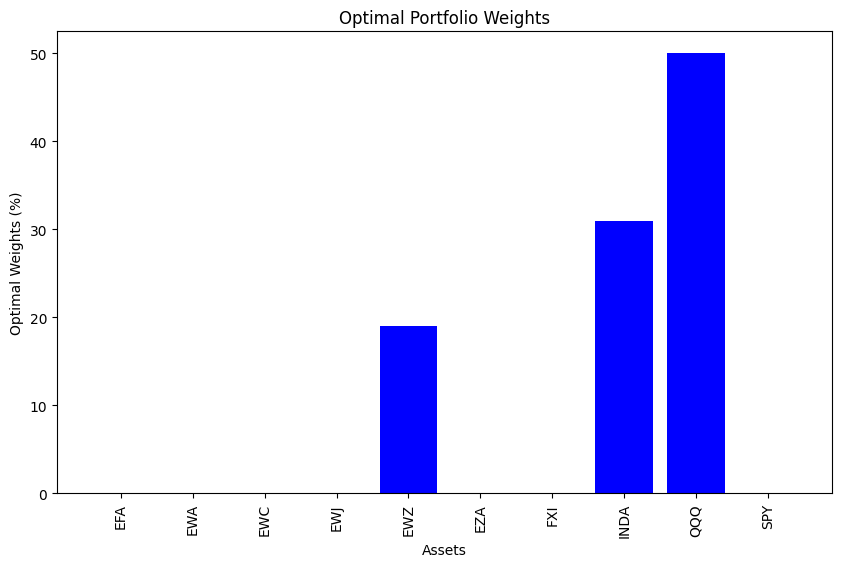

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(assets, optimized_portfolio * 100, color='blue')

plt.xlabel('Assets')
plt.ylabel('Optimal Weights (%)')
plt.title('Optimal Portfolio Weights')
plt.xticks(rotation=90)

plt.show()